In [1]:
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Dict

from dim_est.analysis.plotting_functions_infinite_data import *


In [2]:
def plot_mi_vs_kz_from_df(
    ax,
    results_df,
    *,
    group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
    x_key="kz",
    y_key="max_smoothed_info",
    yerr_key="std_smoothed_info",
    label_fn=None,
    title: Optional[str] = None,
    true_dim: Optional[int] = None,
):
    """
    Plot max-smoothed MI vs k_z from an already-built DataFrame.

    Assumes `results_df` already has columns:
      - x_key           (default 'kz')
      - y_key           (default 'max_smoothed_info')
      - yerr_key        (default 'std_smoothed_info')
      - group_keys      (e.g. 'critic_type', noise level, etc.)
    """
    if results_df is None or results_df.empty:
        ax.text(0.5, 0.5, "No matching runs", ha="center", va="center")
        ax.set_xlabel(r"$k_z$")
        ax.set_ylabel(r"$I_{\rm est}$")
        if title:
            ax.set_title(title)
        return

    if isinstance(group_keys, str):
        group_keys = (group_keys,)          
    else:
        group_keys = tuple(group_keys)

    # Default label_fn: turn group values into a readable string
    if label_fn is None:
        def label_fn(group_vals: tuple):
            parts = []
            for k, v in zip(group_keys, group_vals):
                parts.append(f"{k}={v}")
            return ", ".join(parts)

    for group_vals, df_sub in results_df.groupby(list(group_keys)):
        # scatter + error bars for all runs in this group
        axerr, _, _ = ax.errorbar(
            df_sub[x_key],
            df_sub[y_key],
            yerr=df_sub[yerr_key],
            fmt="o",
            alpha=0.2,
        )

        # aggregate over repeated kz (e.g. max over trials)
        agg = (
            df_sub.groupby(x_key)[y_key]
            .agg(["max"])
            .reset_index()
        )

        label = label_fn(group_vals)

        ax.plot(
            agg[x_key],
            agg["max"],
            label=label,
            linewidth=1.5,
            c=axerr.get_color(),
        )
        ax.scatter(
            agg[x_key],
            agg["max"],
            c=axerr.get_color(),
            alpha=1.0,
        )

    ax.set_xlabel(r"$k_z$")
    ax.set_ylabel(r"$I_{\rm est}$")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if title:
        ax.set_title(title)
    if true_dim is not None:
        ax.axvline(true_dim, ls="--", c="k", alpha=0.2)
    ax.legend()

In [3]:
# from dim_est.utils.h5_result_store import H5ResultStore
# outfile = "h5_results/infinite_data_gaussian_mixture.h5"

# with H5ResultStore(outfile, "r") as rs:
#     for where, context in iter_sweep_queries(sweep_tags, extra_filters):
#         rids = rs.query(where={})

#         for rid in rids:
#             # meta = rs.get_meta(rid)
#             # mu = meta['params']['experiment_cfg']['dataset']['cfg']['latent']['mu']
#             # if mu == 5.0:
#             #     print(meta['params']['experiment_cfg'])


# print(meta['params']['experiment_cfg'])
# print(meta['tags'])
# print(meta['params']['experiment_cfg']['dataset']['cfg']['transform'])


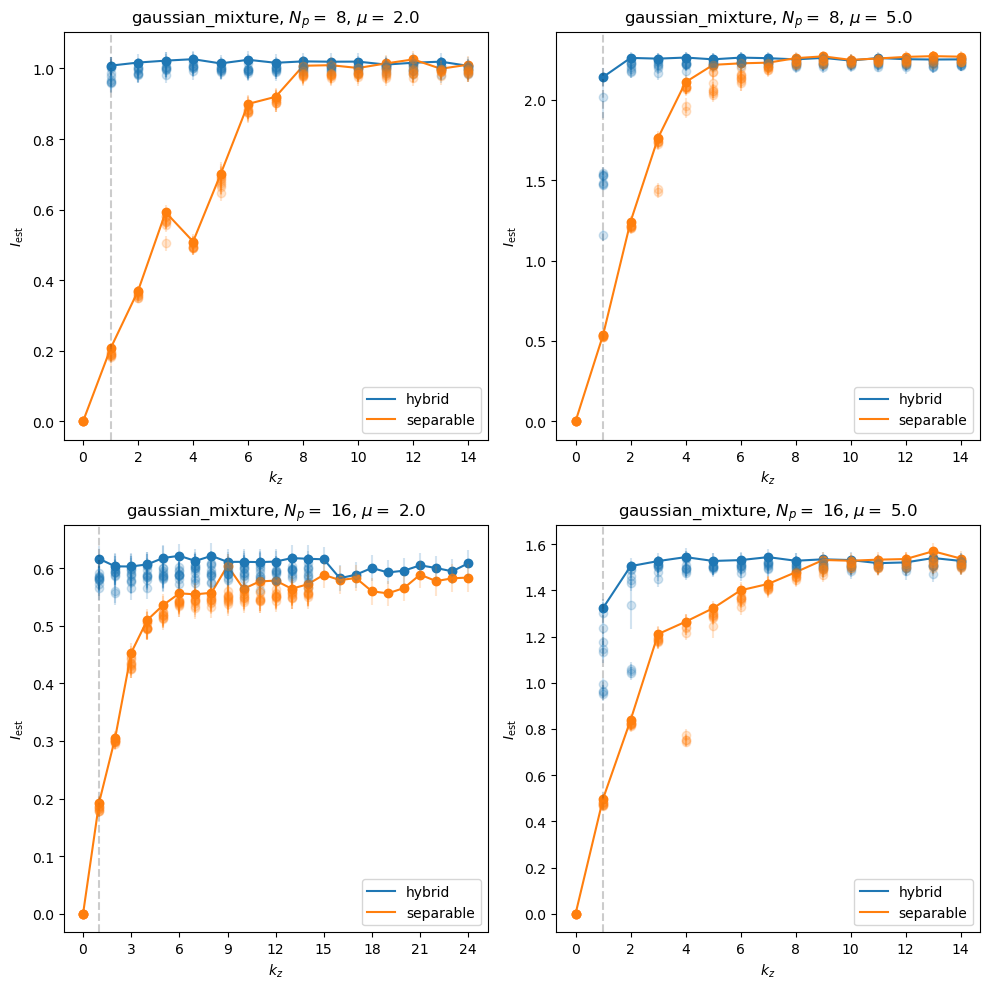

In [5]:
outfile = "h5_results/infinite_data_gaussian_mixture.h5"
dataset_type = 'gaussian_mixture'
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()
mi_bits_peak = 2.0

ii = 0
for n_peaks in [8, 16]:
    for mu in [2.0, 5.0]:
        ax = axes[ii]
        ii +=1
    
        sweep_tags = {
            "tags.dataset_type": [dataset_type],
            "tags.critic_type": ["hybrid", "separable"],
        }
        
        extra_filters = {
            "params.experiment_cfg.dataset.cfg.latent.n_peaks": n_peaks,
            "params.experiment_cfg.dataset.cfg.latent.mu": mu,
            "params.experiment_cfg.dataset.cfg.latent.mi_bits_peak": mi_bits_peak,
            # "tags.n_iter": n_iter,
        }
        
        results_df = load_mi_summary(
            outfile=outfile,
            sweep_tags=sweep_tags,
            extra_filters=extra_filters,
            metric_key="mi_bits",         
            include_meta_keys=[
                "tags.kz",        
            ]
        )
        
        title = rf"{dataset_type}, $N_p =$ {n_peaks}, $\mu =$ {mu}"

        
        def label_fn(group_vals):
                critic_type, = group_vals ## group_vals is always a tuple (read with the comma)
                return rf"{critic_type}"
        
        plot_mi_vs_kz_from_df(
            ax,
            results_df,
            group_keys=["critic_type"],
            x_key="kz",
            y_key="max_smoothed_info",
            yerr_key="std_smoothed_info",
            label_fn=label_fn,
            title=title,
            true_dim=1
        )
        
plt.tight_layout()
plt.show()

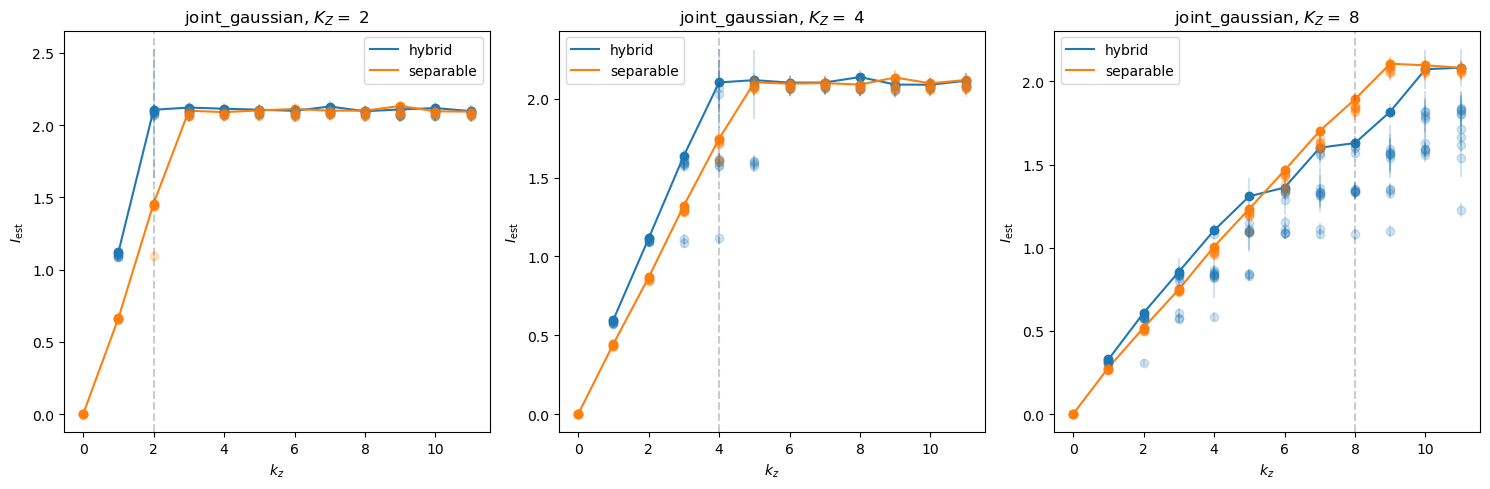

In [6]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
# axes=axes.flatten()
outfile = "h5_results/infinite_data_joint_gaussian.h5"

dataset_type = 'joint_gaussian'
# n_iter =100_000
# lr=1e-5
mi_bits = 2.0

for ii, latent_dim in enumerate([2,4,8]):
    ax=axes[ii]
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable"],
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits": mi_bits,
        # "tags.n_iter": n_iter,
        # "params.experiment_cfg.training.cfg.lr":lr,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        metric_key="mi_bits",
        include_meta_keys=[
            "tags.kz",
        ]
    )

    title = rf"{dataset_type}, $K_Z =$ {latent_dim}"
    
    def label_fn(group_vals):
            critic_type, = group_vals ## group_vals is always a tuple (read with the comma)
            return rf"{critic_type}"
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim
    )
    
plt.tight_layout()
plt.show()

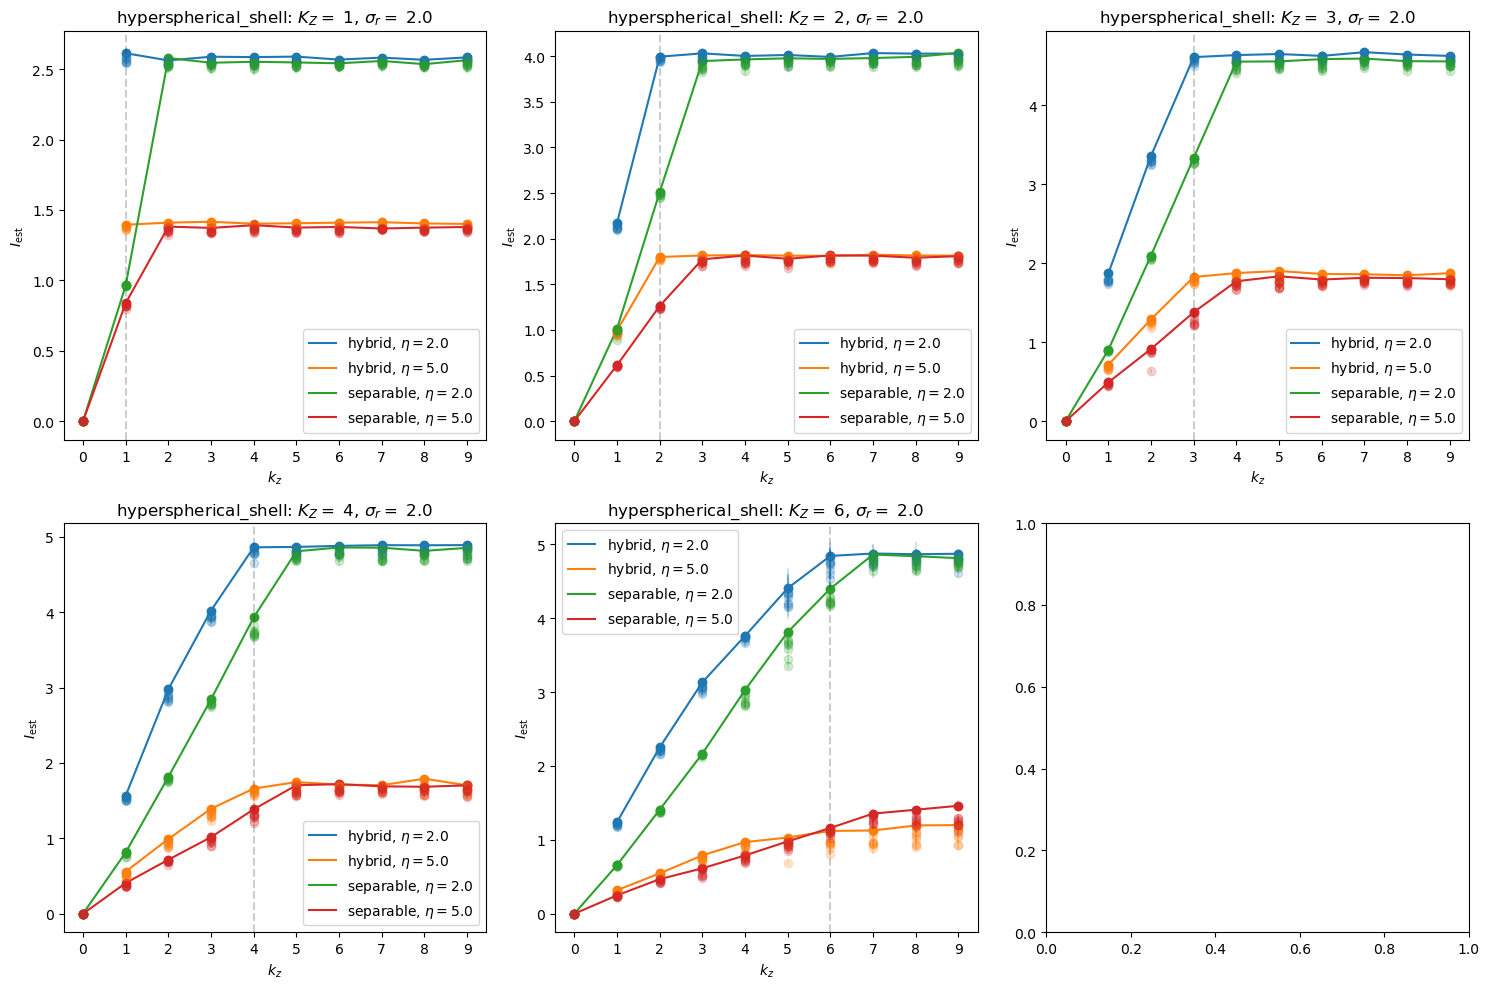

In [7]:
fig, axes  = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
outfile = "h5_results/infinite_data_hyperspherical_shell.h5"
radial_std = 2.0 ## 2.0, or 0.5 results on the cluster

for ii, latent_dim in enumerate([1, 2, 3, 4, 6]):
    ax = axes[ii]
    
    dataset_type = 'hyperspherical_shell'
    # n_iter=20_000
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [2.0, 5.0],
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.radial_std": radial_std,
            # "tags.n_iter": n_iter,
        "tags.estimator": "lclip",
}
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        metric_key="mi_bits",        
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    
    def label_fn(group_vals):
        critic_type, sig_embed = group_vals
        return rf"{critic_type}, $\eta = {sig_embed}$"

    title = rf'{dataset_type}: $K_Z = $ {latent_dim}, $\sigma_r = $ {radial_std} '

    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim,
    )

plt.tight_layout()
plt.show()

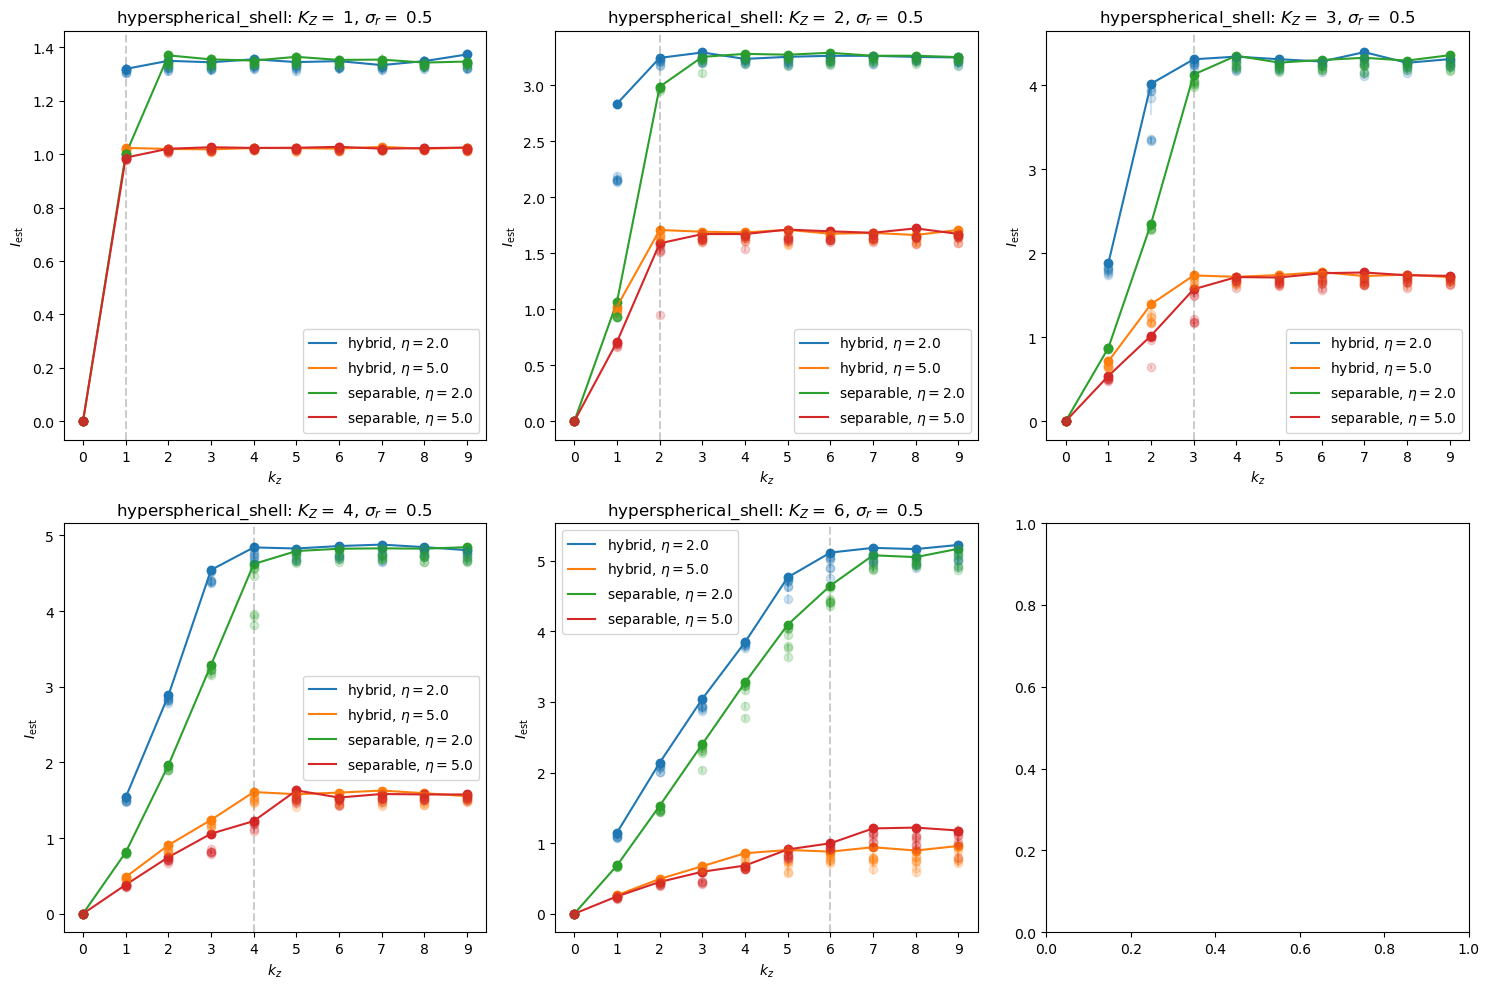

In [8]:
fig, axes  = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
outfile = "h5_results/infinite_data_hyperspherical_shell.h5"
radial_std = 0.5 ## 2.0, or 0.5 results on the cluster

for ii, latent_dim in enumerate([1, 2, 3, 4, 6]):
    ax = axes[ii]
    
    dataset_type = 'hyperspherical_shell'
    # n_iter=20_000
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [2.0, 5.0],
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.radial_std": radial_std,
            # "tags.n_iter": n_iter,
        "tags.estimator": "lclip",
}
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        metric_key="mi_bits",        
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    
    def label_fn(group_vals):
        critic_type, sig_embed = group_vals
        return rf"{critic_type}, $\eta = {sig_embed}$"

    title = rf'{dataset_type}: $K_Z = $ {latent_dim}, $\sigma_r = $ {radial_std} '

    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim,
    )

plt.tight_layout()
plt.show()

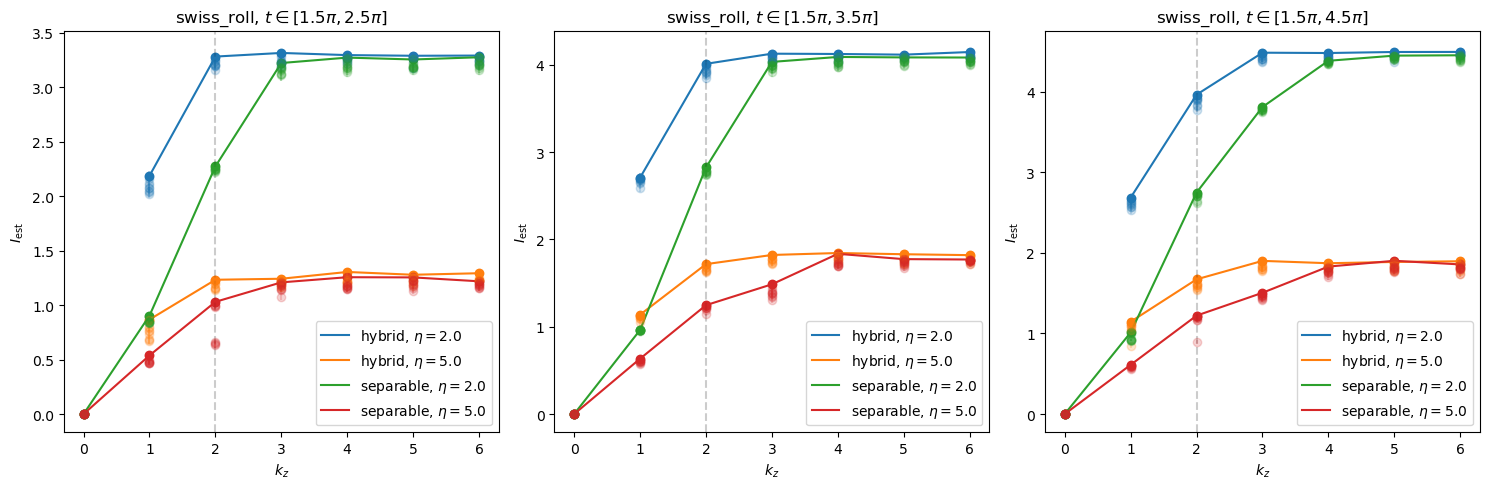

In [9]:
fig, axes  = plt.subplots(1,3, figsize=(15,5))

dataset_type = 'swiss_roll'
outfile = "h5_results/infinite_data_swiss_roll.h5"
latent_dim =3
t_min = 1.5
# n_iter=20_000

for ii, t_max in enumerate([2.5, 3.5, 4.5]): 
    ax = axes[ii]
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [2.0, 5.0], ## same noise was added to x and y, add a check if necessary
    }
        
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.t_min_pi_units": t_min,
        "params.experiment_cfg.dataset.cfg.latent.t_max_pi_units": t_max,
        #     # "tags.n_iter": n_iter,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        metric_key="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    
    def label_fn(group_vals):
        critic_type, sig_embed = group_vals
        return rf"{critic_type}, $\eta = {sig_embed}$"

    title = rf"{dataset_type}, $t \in [{t_min}\pi, {t_max}\pi]$"

    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=2,   # actual latent dim of swiss-roll parameter space
    )
    
plt.tight_layout()
plt.show()

# Hyperparameter optimization

embed_dim: 8; Largest MI: pair hidden dim: 64 pair layers: 1 Encoder hidden dim: 512 Encoder layers dim: 2 lr: 0.0001 n_iter: 50000 MI : 1.852


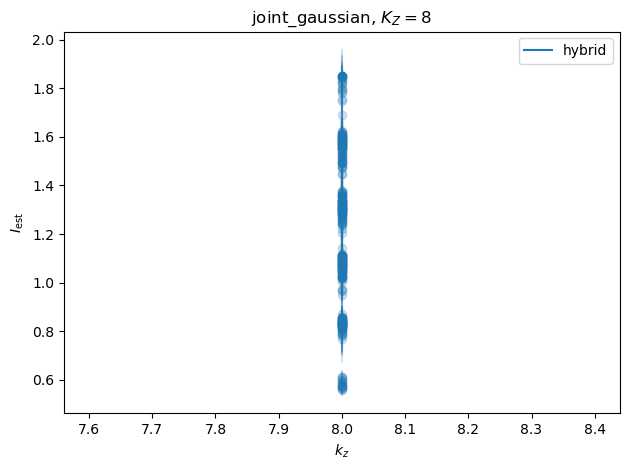

In [29]:
fig, ax = plt.subplots()
# axes=axes.flatten()
outfile = "h5_results/hp_sweep_infinite_joint_gaussian.h5"
dataset_type = 'joint_gaussian'
mi_bits = 2.0
latent_dim = 8


sweep_tags = {
    "tags.dataset_type": [dataset_type],
    "tags.critic_type": ["hybrid", "separable"],
}

extra_filters = {
    "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
    "params.experiment_cfg.dataset.cfg.latent.mi_bits": mi_bits,
    "tags.estimator": "lclip",
}

results_df = load_mi_summary(
    outfile=outfile,
    sweep_tags=sweep_tags,
    extra_filters=extra_filters,
    metric_key="mi_bits",         # whatever your array is called
    include_meta_keys=[
        "params.experiment_cfg.critic.cfg.pair_hidden_dim",
        "params.experiment_cfg.critic.cfg.pair_layers",
        "params.experiment_cfg.critic.cfg.x_hidden_dim",
        "params.experiment_cfg.critic.cfg.x_layers",
        "params.experiment_cfg.training.cfg.lr",
        "tags.kz",
        "tags.n_iter",
    ]
)



for critic_type, df_sub in results_df.groupby("critic_type"):

            
    axerr,_,_ = ax.errorbar(
        df_sub["kz"],
        df_sub["max_smoothed_info"],
        yerr= df_sub["std_smoothed_info"],
        fmt='o', alpha=0.2)

    # compute mean ± std
    agg = (
        df_sub.groupby("kz")["max_smoothed_info"]
        .agg(["max"])
        .reset_index()
    )

    label = f"{critic_type}"


    ax.plot(
        agg["kz"],
        agg["max"],
        label=label,
        linewidth=1.5,  c=axerr.get_color()
        )
    ax.scatter(
        agg["kz"],
        agg["max"],
        c=axerr.get_color(), 
        alpha=1.0
        )

    ## Print the parameters for the best run
    idx_of_max = (df_sub.groupby("kz")["max_smoothed_info"].idxmax())

    # Iterate in order of embed_dim and print
    for _, row in df_sub.loc[idx_of_max].sort_values("kz").iterrows():
        print(
            f'embed_dim: {row["kz"]}; Largest MI:',
            f'pair hidden dim: {row["experiment_cfg.critic.cfg.pair_hidden_dim"]}',
            f'pair layers: {row["experiment_cfg.critic.cfg.pair_layers"]}',
            f'Encoder hidden dim: {row["experiment_cfg.critic.cfg.x_hidden_dim"]}',
            f'Encoder layers dim: {row["experiment_cfg.critic.cfg.x_layers"]}',
            f'lr: {row["experiment_cfg.training.cfg.lr"]}',
            f'n_iter: {row["n_iter"]}',
            f'MI : {row["max_smoothed_info"]:.3f}',
        )

# ax.axvline(low_dim, c='k', ls='--')
# formatting
# ax.set_xscale("log")
ax.set_xlabel(r"$k_z$")
ax.set_ylabel(r"$I_{\rm est}$")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(rf'{dataset_type}, $K_Z = {latent_dim}$' )
# ax.set_ylim([0, 1.5])
plt.tight_layout()
plt.show()